In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from darts import TimeSeries
from darts.models import TCNModel, RNNModel, NBEATSModel, TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, rmse
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

[2022-03-06 15:23:47,406] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-03-06 15:23:47,407] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [2]:
# Read data:

missing_values = ["n/a", "na", "NaN", "--", "null"]
df = pd.read_csv('data/CombinedMacroSectorv4.csv', sep=",", na_values = missing_values, index_col=None)
print(df.shape)

(4275, 22)


In [3]:
df.head()

,Date,Oil,Inflation,CPI,Dollar Index,GDP,Unemployment,Recession,Energy,Gold,...,Customer Discretionary,Consumer Staples,Health,Financials,Technology,Telecommunications,Utilities,Real Estate,Cycle,Spy
0,9/29/04,49.53,2.34,189.8,88.099998,3.8,5.4,0,34.720001,NaN,...,31.070000,21.610001,29.350000,23.176279,19.049999,22.680000,25.000000,49.849998,ExpandBeforePeak,129.00000
1,9/30/04,49.56,2.37,189.8,87.360001,3.8,5.4,0,34.930000,NaN,...,31.200001,21.660000,28.790001,23.119415,19.120001,22.620001,25.049999,50.250000,ExpandBeforePeak,130.09375
2,10/1/04,50.16,2.38,190.8,87.629997,4.1,5.5,0,35.430000,NaN,...,31.590000,21.879999,29.059999,23.509342,19.600000,22.990000,25.250000,51.180000,ExpandBeforePeak,129.43750
3,10/4/04,49.85,2.33,190.8,88.379997,4.1,5.5,0,35.389999,NaN,...,31.889999,21.830000,29.190001,23.541836,19.760000,23.309999,25.350000,51.400002,ExpandBeforePeak,127.81250
4,10/5/04,51.08,2.34,190.8,88.169998,4.1,5.5,0,35.770000,NaN,...,31.850000,21.830000,29.100000,23.411860,19.900000,23.400000,25.459999,51.389999,ExpandBeforePeak,130.12500


In [4]:
df['time'] = pd.to_datetime(df['Date'],utc=True)
df['time']= df.time.dt.tz_localize(None)
#df['Time'] = normalize(df)
#df['Class'] = df['Recession']
#std_normalize(["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
#"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
#"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"], df)
df.drop(['Date'], axis=1, inplace=True)
#df.drop(['Cycle'], axis=1, inplace=True)
#df.drop(['Gold'], axis=1, inplace=True)

#ts = scaler.fit_transform(
#    ts
#)  # scale the whole time series not caring about train/val split...

In [5]:
daily_cov = pd.read_csv('data/news_sentiment_data.csv', sep=",", na_values = missing_values, index_col=None)
print(daily_cov.shape)

(5985, 2)


In [6]:
daily_cov.head()

,date,sentiment
0,9/29/04,0.167411
1,9/30/04,0.173788
2,10/1/04,0.167044
3,10/2/04,0.161869
4,10/3/04,0.165404


In [7]:
daily_cov['time'] = pd.to_datetime(daily_cov['date'],utc=True)
daily_cov['time']= daily_cov.time.dt.tz_localize(None)
daily_cov.drop(['date'], axis=1, inplace=True)
#daily_cov = daily_cov.time.isin(df.time)
daily_cov = daily_cov[daily_cov.time.isin(df.time)]
print(daily_cov.shape)

(4275, 2)


<AxesSubplot:>

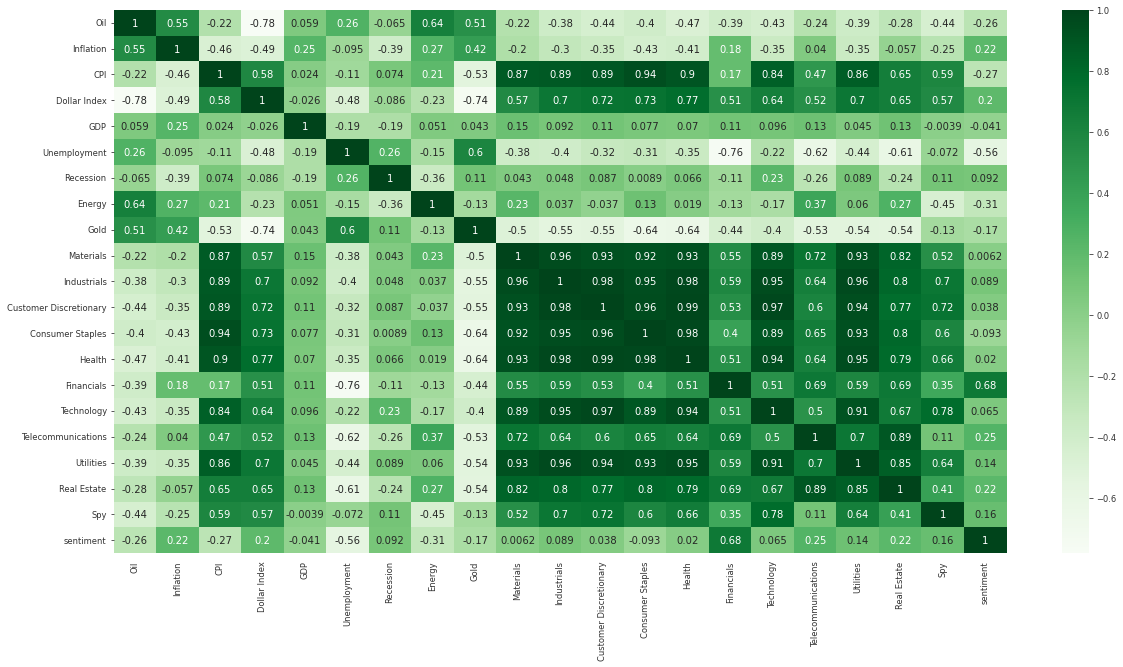

In [8]:
result = pd.concat([df, daily_cov], axis=1).corr()
sns.heatmap(result, cmap="Greens",annot=True)

In [9]:
series_cov = TimeSeries.from_dataframe(daily_cov, 'time', ["sentiment"])

In [10]:
scaler_cov = Scaler(MinMaxScaler(feature_range=(-1, 1)))
series_cov_transformed = scaler_cov.fit_transform(
    series_cov
)

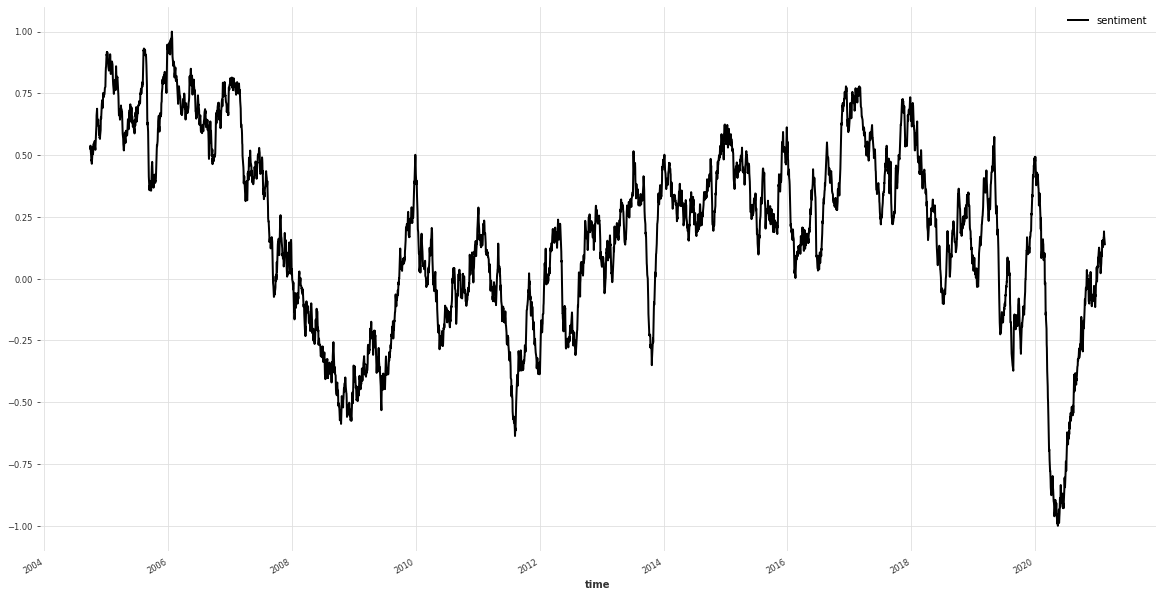

In [11]:
train_cov, val_cov =  series_cov_transformed.split_after(pd.Timestamp('20170901'))
series_cov_transformed.plot()

In [12]:
columns = ["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"]

series = TimeSeries.from_dataframe(df, 'time', ['Oil', "CPI", "Dollar Index", "Spy"])

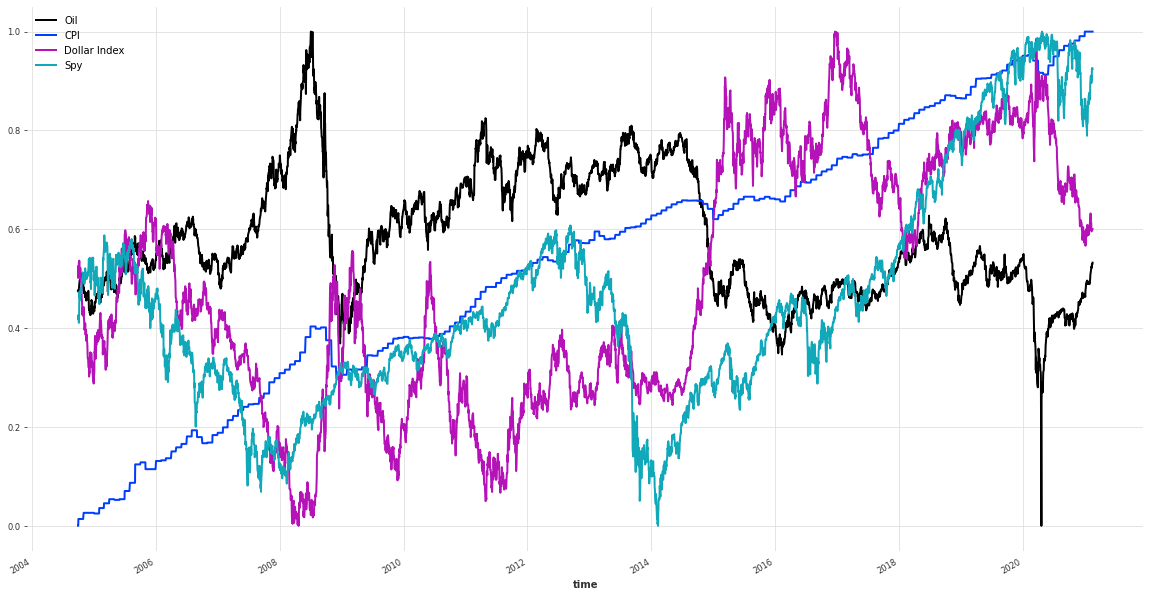

In [13]:
scaler = Scaler()
series_transformed = scaler.fit_transform(
    series
)  #scale the whole time series not caring about train/val split..

train, val =  series_transformed.split_after(pd.Timestamp('20170901'))
series_transformed.plot()

In [14]:
seasonality = check_seasonality(series_transformed["Spy"], max_lag=series_transformed.n_timesteps)
print(seasonality)

(True, 1943)


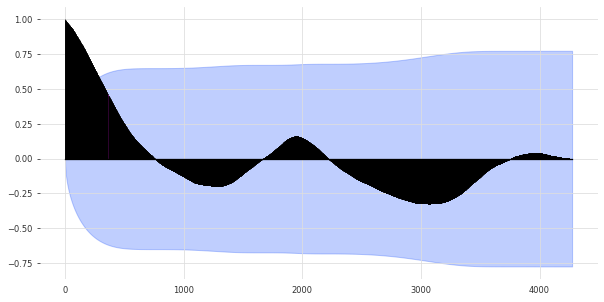

In [15]:
plot_acf(series_transformed["Spy"], 365, max_lag=series_transformed.n_timesteps-1)

In [16]:
stationary = stationarity_tests(series_transformed["Spy"])
print(stationary)

False


/opt/homebrew/Caskroom/miniforge/base/envs/python_m1/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [17]:
def tft_model(hiddensize, layers, attention, train_series, val_series, past_covariates_train=None, past_covariates_val=None, future_covariates_train=None, future_covariates_val=None):

    # default quantiles for QuantileRegression
    quantiles = [
        0.01,
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        0.99,
    ]

    model = TFTModel(
        input_chunk_length=365,
        output_chunk_length=7,
        n_epochs=100,
        hidden_size=hiddensize,
        lstm_layers=layers,
        num_attention_heads=attention,
        nr_epochs_val_period=10,
        dropout=0.1,
        batch_size=16,
        add_relative_index=False,
        add_encoders={'cyclic': {'future': ['month']}},
        likelihood=QuantileRegression(
            quantiles=quantiles
        ),  # QuantileRegression is set per default
        log_tensorboard=True,
        model_name="tft",
        # loss_fn=MSELoss(),
    )

    model.fit(
        series=train_series,
        val_series=val_series,
        past_covariates=past_covariates_train,
        val_past_covariates=past_covariates_val,
        future_covariates=future_covariates_train,
        val_future_covariates=future_covariates_val,
        #verbose=True,
    )

    return model

In [18]:
def eval_model(model, series, past_covariates=None, future_covariates=None):
    backtest = model.historical_forecasts(
        series=series,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.7,
        forecast_horizon=7,
        stride=10,
        retrain=False,
        #verbose=True,
    )
    series.plot(label="actual")
    backtest.plot(label="backtest (H=7 day)")
    r2_score_value = r2_score(series, backtest)
    plt.title('R2:' + str(r2_score_value))
    plt.legend()
    print('Backtest RMSE = {}'.format(rmse(series, backtest)))

In [19]:
def save_model(model, val_series):
    import torch.onnx
    dummy_input = torch.randn(1, val_series.width, requires_grad=True)
    input_names = [ "macro_sector_news" ]
    output_names = [ "price" ]

    torch.onnx.export(model, dummy_input, "tft.onnx", export_params=True, verbose=True, input_names=input_names, output_names=output_names)

In [20]:
model = tft_model(32, 1, 4, train, val) #was 5
model.save_model('tft_32.pth.tar')

[2022-03-06 15:23:51,144] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 15:23:51,144] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 15:23:51,154] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-06 15:23:51,154] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 6.0 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.1475423634739727


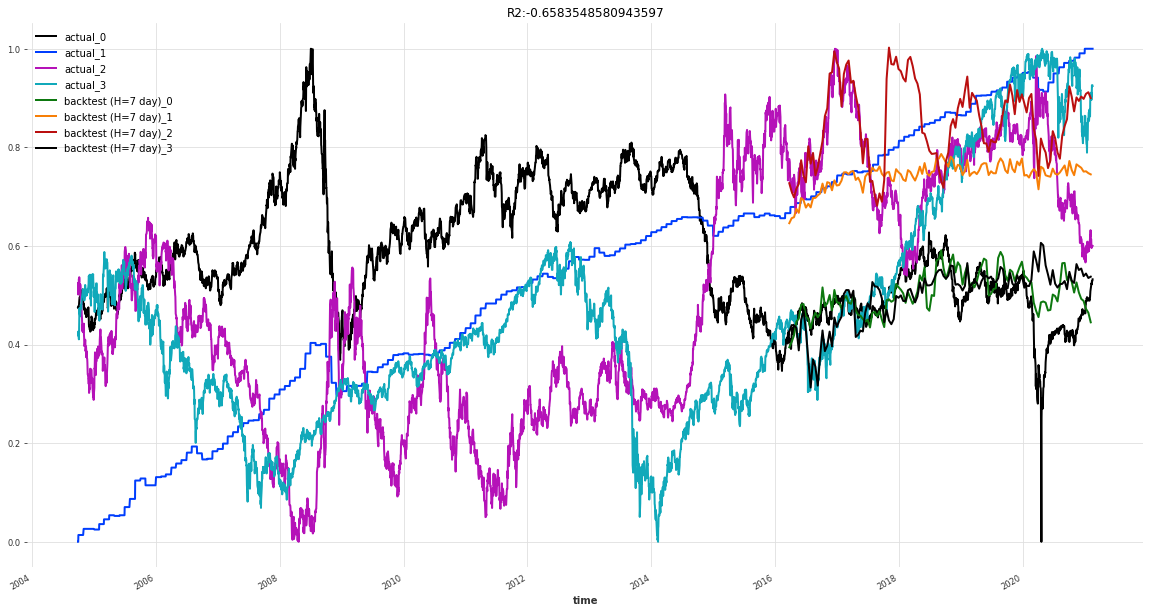

In [21]:
eval_model(model, series_transformed)

In [22]:
model = tft_model(32, 1, 4, train, val, train_cov, val_cov)

[2022-03-06 16:51:26,944] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 16:51:26,944] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 16:51:26,953] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-06 16:51:26,953] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 7.1 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.1553492392326605


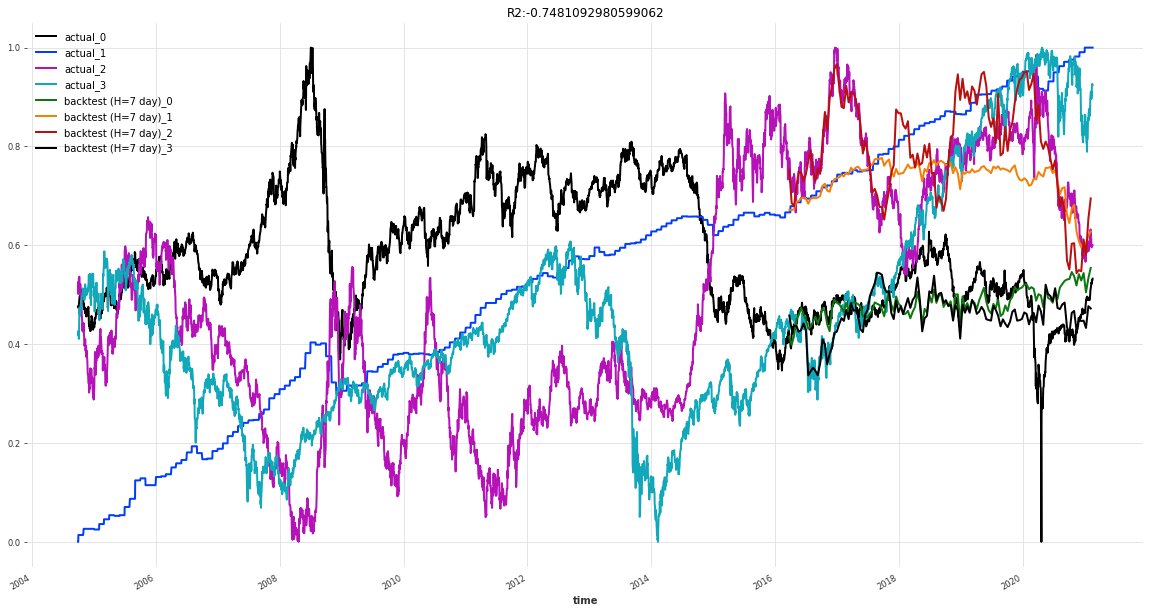

In [23]:
eval_model(model, series_transformed, series_cov_transformed)

In [24]:
model = tft_model(16, 1, 4, train, val)

[2022-03-06 19:24:11,674] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 19:24:11,674] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 19:24:11,682] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-06 19:24:11,682] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 3.7 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.13671175229973792


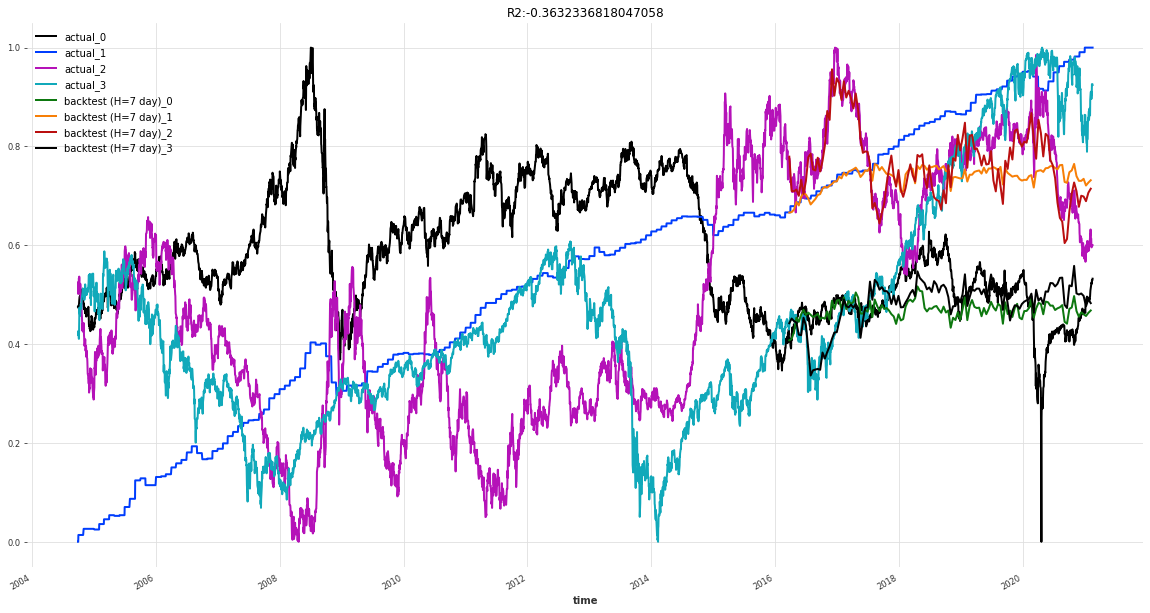

In [25]:
eval_model(model, series_transformed)

In [26]:
model = tft_model(16, 1, 4, train, val, train_cov, val_cov)

[2022-03-06 21:43:50,279] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 21:43:50,279] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-06 21:43:50,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-06 21:43:50,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 4.4 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.1549803883800822


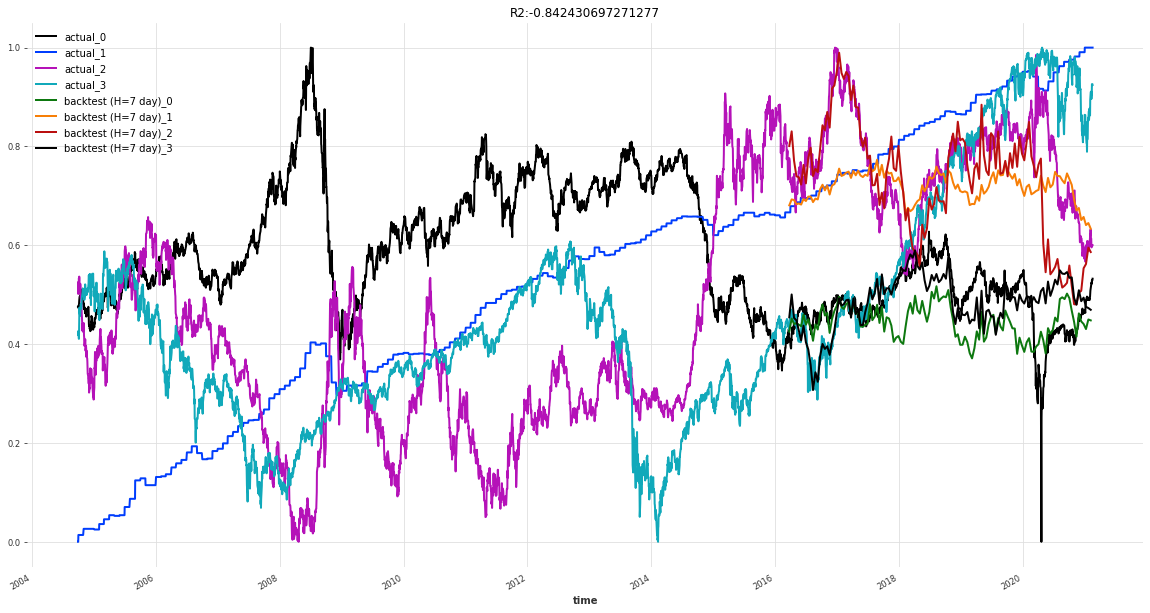

In [27]:
eval_model(model, series_transformed, series_cov_transformed)

In [28]:
model = tft_model(24, 1, 4, train, val)

[2022-03-07 02:46:39,609] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 02:46:39,609] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 02:46:39,616] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 02:46:39,616] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 4.9 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.18258915335188786


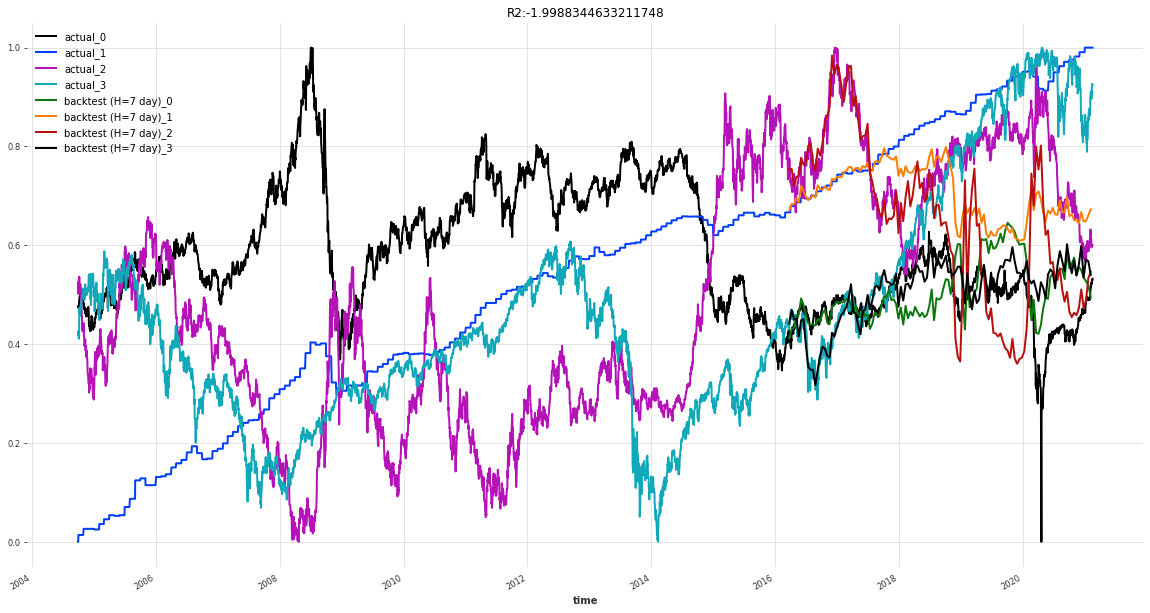

In [29]:
eval_model(model, series_transformed)

In [30]:
model = tft_model(24, 1, 4, train, val, train_cov, val_cov)

[2022-03-07 04:40:38,817] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 04:40:38,817] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 04:40:38,826] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 04:40:38,826] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 5.8 K 
2  | decoder_vsn        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Backtest RMSE = 0.16818325818930002


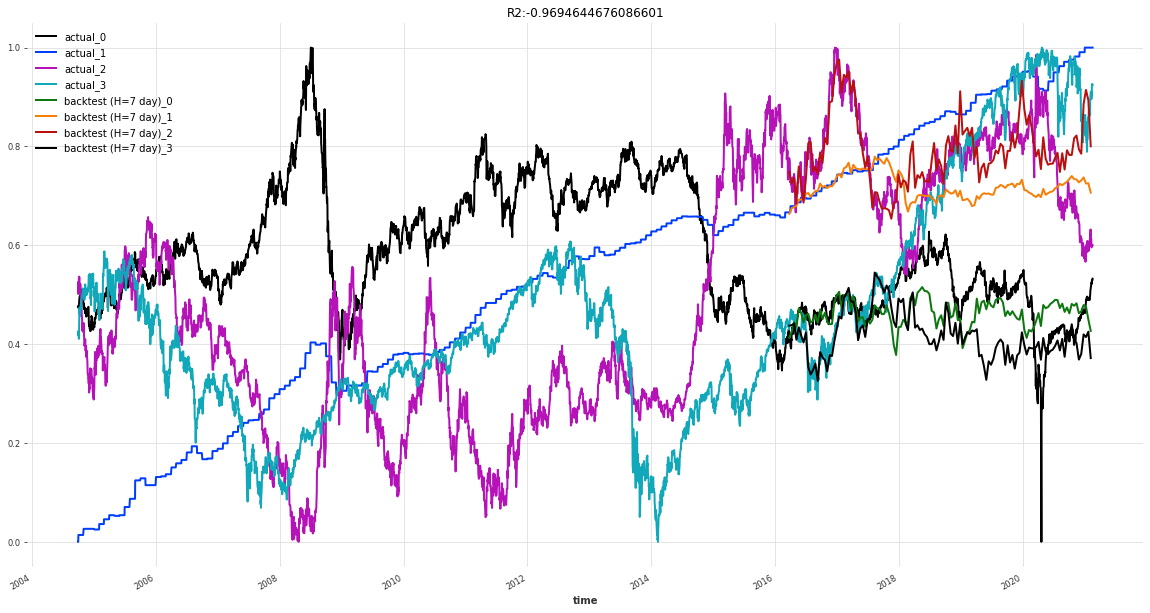

In [31]:
eval_model(model, series_transformed, series_cov_transformed)